<a href="https://colab.research.google.com/github/0xpix/Food_vision/blob/main/Food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food vision big 🍕🍣🍨

## Importing libraries

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Tensorflow
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomHeight, RandomWidth, Input, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

## Creating some helping functions

In [99]:
# create some functions

# comparing histories between feature extraction and fine tuning plots
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["Accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_Accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["Accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_Accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# -------------------------------------------------------------------
# -------------------------------------------------------------------
# -------------------------------------------------------------------

# Create confusion matrix
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  # if savefig:
  #   fig.savefig("confusion_matrix.png")

## Download the dataset using `dstf`

In [3]:
import tensorflow_datasets as dstf
# check if food101 is in the dataset
datasets_list = dstf.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list)

True


In [4]:
""" 
name (str) : the target dataset (e.g. "food101")
split (list, optional) : what splits of the dataset we're after (e.g. ["train", "validation"])
the split parameter is quite tricky. See the documentation for more.
shuffle_files (bool) : whether or not to shuffle the files on download, defaults to False
as_supervised (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
with_info (bool) : True to download dataset metadata (labels, number of samples, etc) """

(train_data, test_data), ds_info = dstf.load(name='food101',
                                             split=['train', 'validation'],
                                             as_supervised=True,
                                             with_info=True

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete47NWTG/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete47NWTG/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the dataset
we need to find:
- the class names
- the shape of the data
- the datatype of the data
- what labels look like (one-hot encoded or label encoded)
- do the labels match up with the class names?

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# get the class names
class_names = ds_info.features['label'].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

the image shape: (512, 512, 3),
the image data type: <dtype: 'uint8'>
the image label: 56,
the label name: huevos_rancheros



(-0.5, 511.5, 511.5, -0.5)

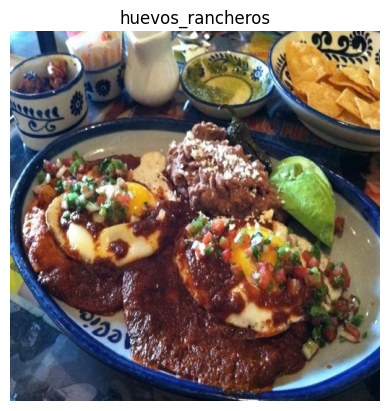

In [7]:
## infos about the images

# get a smaller random sample from the train_data
ds_sample = train_data.take(1) # samples are in format (image_tensor, label)

# get the shape, dtype and the label of a random image
for image, label in ds_sample:
  print(f"""the image shape: {image.shape},
the image data type: {image.dtype}
the image label: {label},
the label name: {class_names[label.numpy()]}
""")

# plot image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [8]:
# get the max and min value of the image
print(f"""the min value: {tf.reduce_min(image)},
the max value: {tf.reduce_max(image)}""")

the min value: 0,
the max value: 255


## Preprocesing the data 💻:

### Preprocessing function:
our data is currently:
- In uint8 data type
- Comprised of all differnet sized tensors (different sized images)
- Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:
- In float32 data type
- Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
- Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a preprocess_img() function which:
- Resizes an input image tensor to a specified size using tf.image.resize()
- Converts an input image tensor's current datatype to tf.float32 using tf.cast()

In [9]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [10]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"""the image \n{image} \nshape and dtype before resizing: {image.shape} and the dtype {image.dtype},\n
the image \n{preprocessed_img} \nshape after getting resized: {preprocessed_img.shape} and the dtype {preprocessed_img.dtype}""")

the image 
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]

 [[228 254 253]
  [226 255 253]
  [223 255 252]
  ...
  [164 159 155]
  [145 141 138]
  [128 127 125]]

 ...

 [[ 66 112 164]
  [ 67 113 163]
  [ 55  99 148]
  ...
  [  5  14  23]
  [  9  18  27]
  [  8  17  26]]

 [[ 76 123 177]
  [ 75 122 176]
  [ 70 116 168]
  ...
  [  5  14  23]
  [  9  18  25]
  [  7  16  23]]

 [[ 80 129 185]
  [ 71 121 174]
  [ 74 121 175]
  ...
  [  7  16  25]
  [ 11  20  27]
  [ 10  19  26]]] 
shape and dtype before resizing: (512, 512, 3) and the dtype <dtype: 'uint8'>,

the image 
[[[230.65816   253.64285   251.       ]
  [222.99998   254.97449   252.19388  ]
  [207.06633   255.        250.36734  ]
  ...
  [140.66287   129.52519   121.22428  ]
  [121.14268   115.26515   116.95397  ]
  [ 83.95363    83.08119    89.63737  ]]

 [[221.47449   254.

### Batch & prepare datasets:

**we're going to be using:**
- `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
- `shuffle()` - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
- `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
- **Extra:** `cache()` - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

**Things to note:**
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as map()), setting it to `num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory
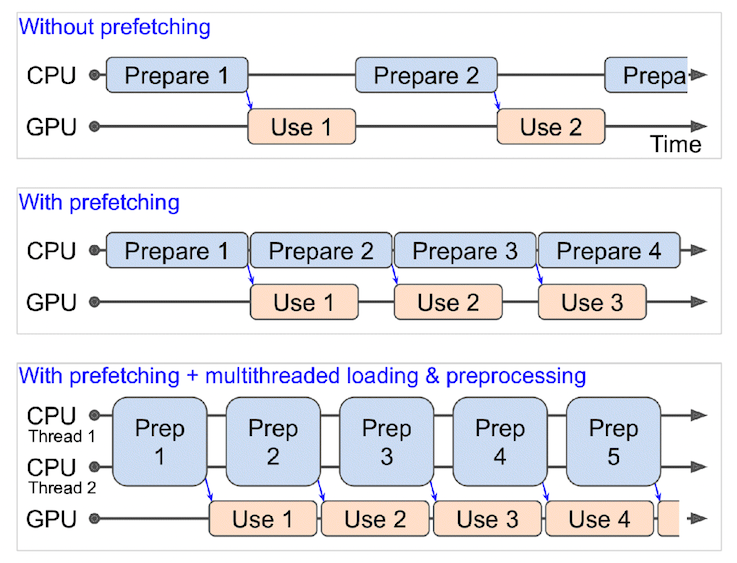

In [11]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
print(f"""after getting prepared.
Train data : {train_data},
Test data : {test_data}""")

after getting prepared.
Train data : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
Test data : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Create modelling callbacks:

In [13]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoint/cp.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=0,
                             save_vest_only=True,
                             save_weights_only=True,
                             )

### Setup mixed precision training
when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

In [14]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee616f7d-26b2-db40-9832-b4bb654b621a)


In [15]:
from keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16') # Dtype policies specify the dtypes layers will run in.

In [16]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

## Build feature extraction model:
- Build a feature extraction model (replace the top few layers of a pretrained model)
- Train for a few epochs with lower layers frozen
- Fine-tune if necessary with multiple layers unfrozen

In [17]:
from keras.applications import EfficientNetB0

# the base model (EfficientNetB0)
input_shape = (224, 224, 3)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = GlobalAveragePooling2D(name='pooling_layer')(x)
x = Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = Model(inputs, outputs)

# compile the model
model.compile(loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=Adam(learning_rate=0.0001),
              metrics=['Accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Checking layer dtype policies:

In [19]:
# Check the dtype_policy attributes of layers in our model
"""
layer.name (str) : a layer's human-readable name, can be defined by the name parameter on construction
layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
layer.dtype : the data type a layer stores its variables in
layer.dtype_policy : the data type a layer computes in"""

for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers
  

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


### Fit the feature extraction model

In [20]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# fit the model with checkpoint callback
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15*len(test_data)),
                                       callbacks=[checkpoint])  

Epoch 1/3
2368/2368 [==============================] - 191s 74ms/step - loss: 3.0214 - Accuracy: 0.3917 - val_loss: 2.0319 - val_Accuracy: 0.5749
Epoch 2/3
2368/2368 [==============================] - 184s 77ms/step - loss: 1.9347 - Accuracy: 0.5720 - val_loss: 1.5736 - val_Accuracy: 0.6361
Epoch 3/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.6454 - Accuracy: 0.6133 - val_loss: 1.3948 - val_Accuracy: 0.6581


In [21]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 65ms/step - loss: 1.4083 - Accuracy: 0.6581


[1.4082512855529785, 0.658138632774353]

## Fine tuning our model

In [22]:
# unfroze all the layers
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # making sure our model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


### More callbacks
The `EarlyStopping` callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

the `ModelCheckpoint` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

In [23]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                               patience=3)         # if val loss decreases for 3 epochs in a row, stop training

# fine-tune checkpoint callback
checkpoint_path = "fine_tune_checkpoints/"
tune_checkpoint = ModelCheckpoint(checkpoint_path,
                                  monitor='val_loss',
                                  save_best_only=True)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

### Compile the model
We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (1e-4 instead of 1e-3).

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['Accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

### Fit the model
Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with unoptimized data pipelines and without mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs)

In [28]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# fit the model
history_fine_tuning = model.fit(train_data,
                                epochs=100,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.15*len(test_data)),
                                callbacks=[early_stopping,
                                           reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 316s 133ms/step - loss: 0.4163 - Accuracy: 0.8831 - val_loss: 0.8091 - val_Accuracy: 0.7892 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 317s 133ms/step - loss: 0.2150 - Accuracy: 0.9370 - val_loss: 0.8945 - val_Accuracy: 0.7924 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.1272 - Accuracy: 0.9606
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 318s 133ms/step - loss: 0.1272 - Accuracy: 0.9606 - val_loss: 1.0356 - val_Accuracy: 0.7858 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 333s 140ms/step - loss: 0.0313 - Accuracy: 0.9914 - val_loss: 1.0445 - val_Accuracy: 0.8162 - lr: 2.0000e-05


In [29]:
result_fine_tuning = model.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 1.0794 - Accuracy: 0.8114


3
7
[0.39174917340278625, 0.5719736218452454, 0.6132805347442627, 0.883102297782898, 0.937016487121582, 0.9605808854103088, 0.9913531541824341]


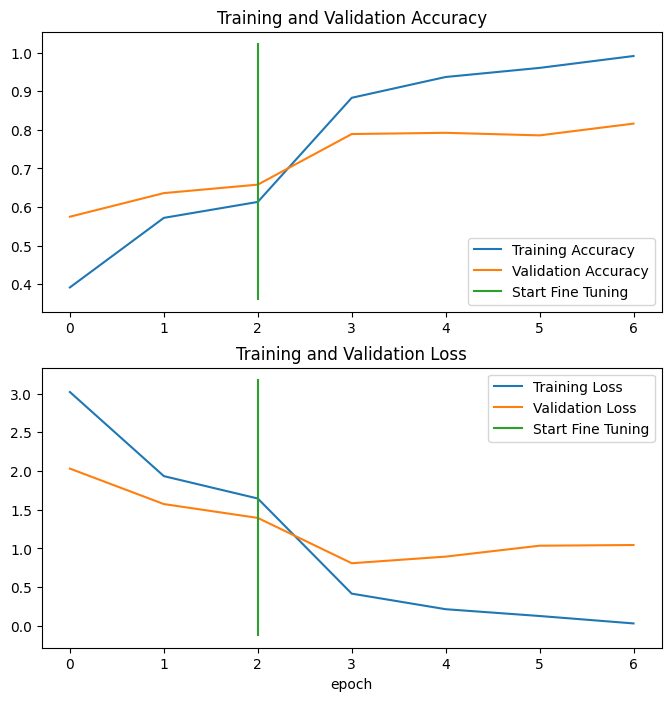

In [98]:
compare_historys(history_feature_extraction, history_fine_tuning, initial_epochs=3)

## Evaluate the model
Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
- A confusion matrix between all of the model's predictions and true labels.
- A graph showing the f1-scores of each class.
- A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
- For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

- Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?

Name one important benefit of mixed precision training, how does this benefit take place?

### Creating a confusion matrix function

In [30]:
pred_prob = model.predict(test_data)

790/790 [==============================] - 53s 64ms/step


In [52]:
# get the max value for each prediction
pred_classes = pred_prob.argmax(axis=1)
pred_classes

array([29, 81, 91, ..., 46, 31, 21])

In [42]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy()) # if the labels are hot-encoded we use .argmax()
  
y_labels[:10] 

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [43]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

### Accuracy

In [44]:
# Get accuracy score by comparing predicted classes to ground truth labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8114455445544555

### classification_report

In [45]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       250
           1       0.85      0.78      0.81       250
           2       0.85      0.88      0.86       250
           3       0.86      0.80      0.83       250
           4       0.78      0.77      0.78       250
           5       0.74      0.69      0.71       250
           6       0.82      0.90      0.86       250
           7       0.91      0.90      0.91       250
           8       0.63      0.62      0.63       250
           9       0.81      0.62      0.70       250
          10       0.79      0.74      0.76       250
          11       0.81      0.89      0.85       250
          12       0.89      0.86      0.87       250
          13       0.75      0.82      0.78       250
          14       0.83      0.81      0.82       250
          15       0.72      0.68      0.70       250
          16       0.64      0.75      0.69       250
          17       0.86    

### F1-score


In [55]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6224899598393574,
  'recall': 0.62,
  'f1-score': 0.6212424849699398,
  'support': 250},
 '1': {'precision': 0.851528384279476,
  'recall': 0.78,
  'f1-score': 0.8141962421711899,
  'support': 250},
 '2': {'precision': 0.8461538461538461,
  'recall': 0.88,
  'f1-score': 0.8627450980392156,
  'support': 250},
 '3': {'precision': 0.8626609442060086,
  'recall': 0.804,
  'f1-score': 0.8322981366459626,
  'support': 250},
 '4': {'precision': 0.7813765182186235,
  'recall': 0.772,
  'f1-score': 0.7766599597585513,
  'support': 250},
 '5': {'precision': 0.7361702127659574,
  'recall': 0.692,
  'f1-score': 0.71340206185567,
  'support': 250},
 '6': {'precision': 0.8241758241758241,
  'recall': 0.9,
  'f1-score': 0.8604206500956023,
  'support': 250},
 '7': {'precision': 0.9146341463414634,
  'recall': 0.9,
  'f1-score': 0.9072580645161291,
  'support': 250},
 '8': {'precision': 0.6326530612244898,
  'recall': 0.62,
  'f1-score': 0.6262626262626263,
  'support': 250},
 '9

In [48]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6212424849699398,
 'baby_back_ribs': 0.8141962421711899,
 'baklava': 0.8627450980392156,
 'beef_carpaccio': 0.8322981366459626,
 'beef_tartare': 0.7766599597585513,
 'beet_salad': 0.71340206185567,
 'beignets': 0.8604206500956023,
 'bibimbap': 0.9072580645161291,
 'bread_pudding': 0.6262626262626263,
 'breakfast_burrito': 0.7029478458049886,
 'bruschetta': 0.7628865979381443,
 'caesar_salad': 0.8511450381679388,
 'cannoli': 0.8739837398373983,
 'caprese_salad': 0.7832699619771862,
 'carrot_cake': 0.81947261663286,
 'ceviche': 0.6993865030674847,
 'cheesecake': 0.6937269372693727,
 'cheese_plate': 0.864,
 'chicken_curry': 0.7300380228136881,
 'chicken_quesadilla': 0.803921568627451,
 'chicken_wings': 0.8624999999999999,
 'chocolate_cake': 0.724,
 'chocolate_mousse': 0.629126213592233,
 'churros': 0.8857142857142858,
 'clam_chowder': 0.8695652173913043,
 'club_sandwich': 0.8732394366197184,
 'crab_cakes': 0.7321772639691715,
 'creme_brulee': 0.8549019607843137,
 'croque_m

In [49]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33            edamame  0.985972
63           macarons  0.951020
75                pho  0.940000
51          guacamole  0.934653
54  hot_and_sour_soup  0.932806
..                ...       ...
8       bread_pudding  0.626263
0           apple_pie  0.621242
77          pork_chop  0.615385
39          foie_gras  0.593684
93              steak  0.533074

[101 rows x 2 columns]

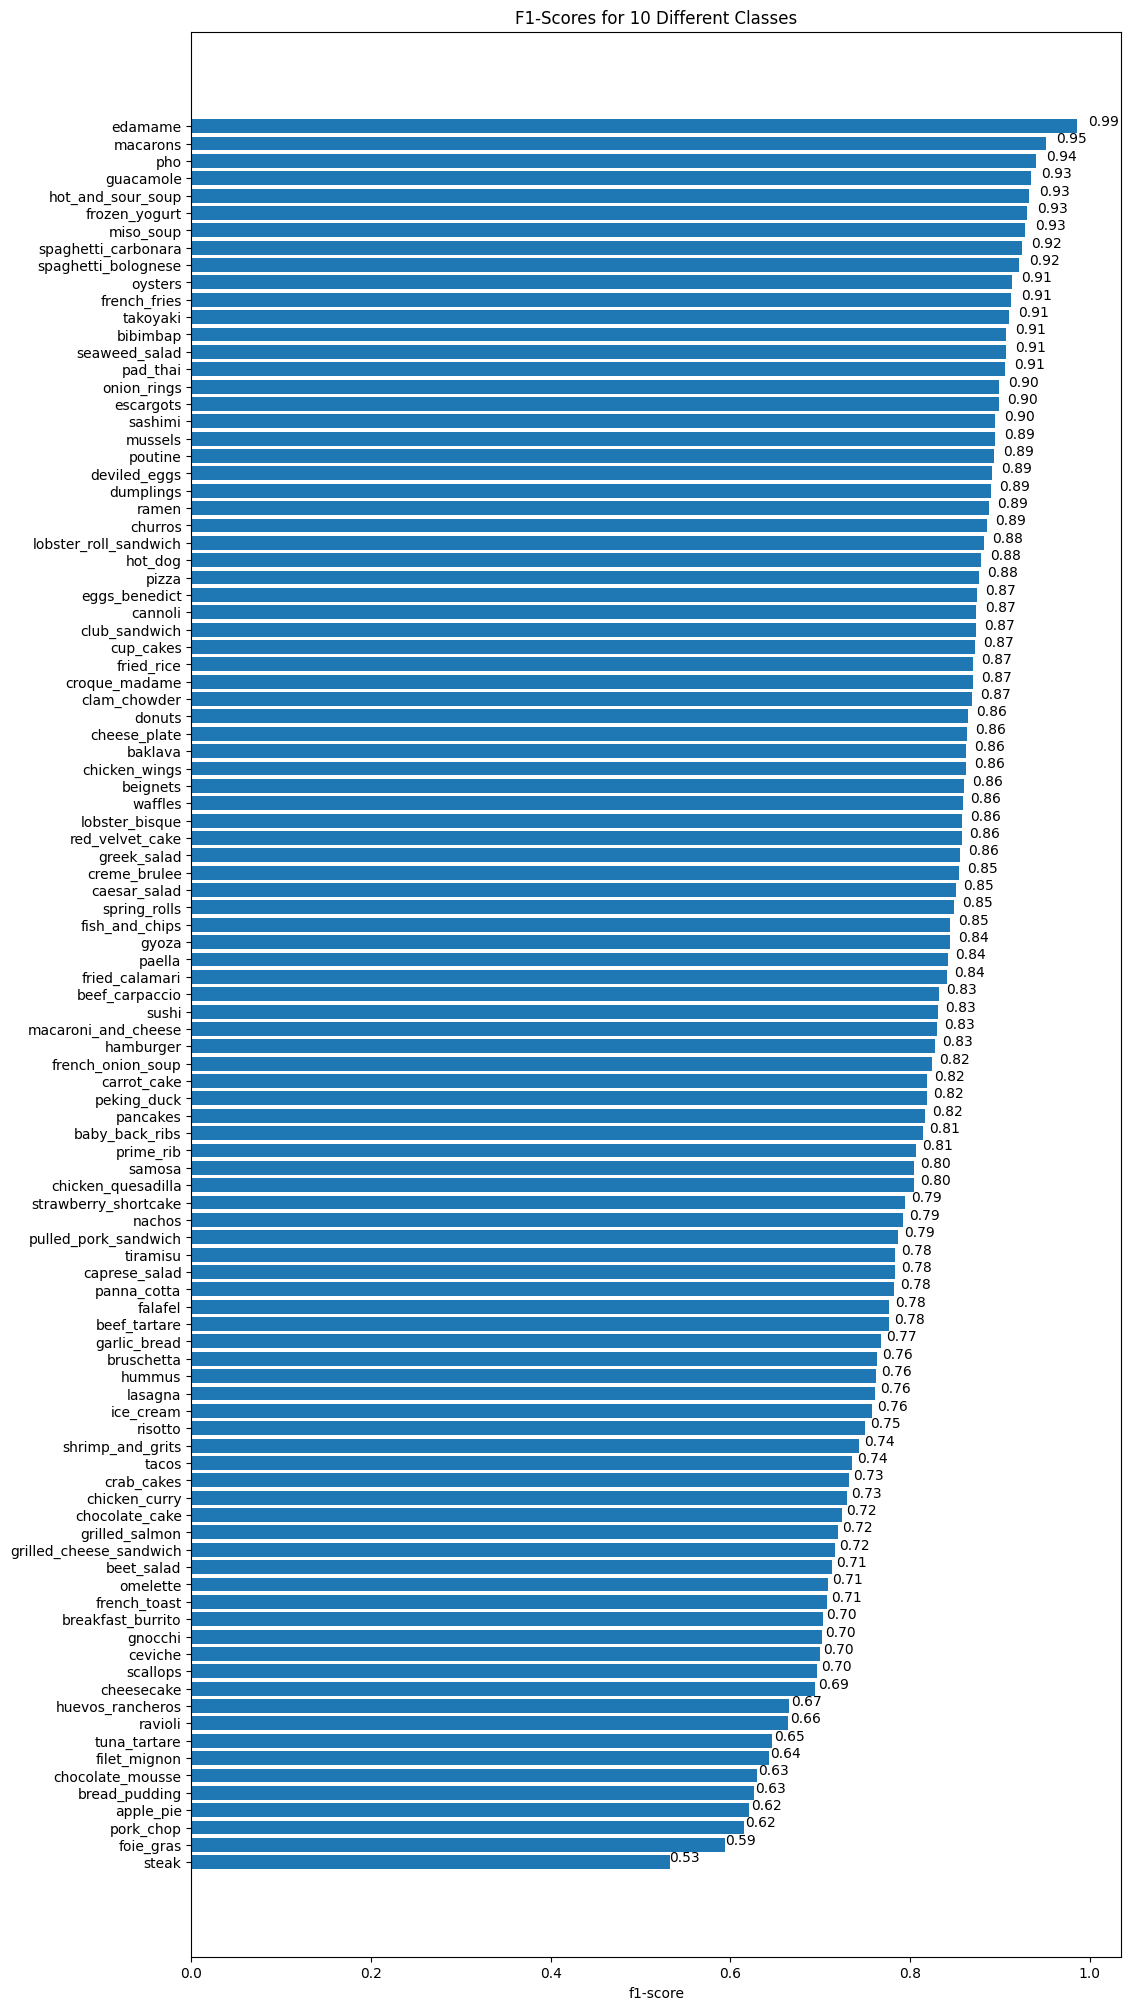

In [50]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Fine tuning using EfficientNetB4

### Base model

In [58]:
from keras.applications import EfficientNetB4

# the base model (EfficientNetB0)
input_shape = (224, 224, 3)
base_model_B4 = EfficientNetB4(include_top=False)
base_model_B4.trainable = False

# Create functional model
inputs = Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model_B4(inputs, training=False) # set base_model to inference mode only
x = GlobalAveragePooling2D(name='pooling_layer')(x)
x = Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_2 = Model(inputs, outputs)

# compile the model
model_2.compile(loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=Adam(learning_rate=0.0001),
              metrics=['Accuracy'])

71686520/71686520 [==============================] - 4s 0us/step


In [59]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-trai

### Fit the model

In [61]:
history_B4_feature_extraction = model_2.fit(train_data,
                                          epochs=3,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 251s 99ms/step - loss: 2.9354 - Accuracy: 0.4024 - val_loss: 1.9927 - val_Accuracy: 0.5622
Epoch 2/3
2368/2368 [==============================] - 259s 108ms/step - loss: 1.9421 - Accuracy: 0.5469 - val_loss: 1.6199 - val_Accuracy: 0.6131
Epoch 3/3
2368/2368 [==============================] - 238s 99ms/step - loss: 1.7012 - Accuracy: 0.5853 - val_loss: 1.4709 - val_Accuracy: 0.6351


In [62]:
result_feature_extraction_B4 = model_2.evaluate(test_data)

790/790 [==============================] - 68s 86ms/step - loss: 1.4842 - Accuracy: 0.6305


### Fine tuning

In [65]:
# fine tune
for layer in model_2.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### recompile the model

In [66]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['Accuracy'])

In [69]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 17,729,709
Non-t

#### fit the model

In [68]:
history_B4_fine_tuning = model_2.fit(test_data,
                                     epochs=100,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=int(0.15*len(test_data)),
                                     callbacks=[reduce_lr,
                                                early_stopping])

Epoch 1/100
2368/2368 [==============================] - 272s 102ms/step - loss: 1.0521 - Accuracy: 0.7121 - val_loss: 0.5264 - val_Accuracy: 0.8612 - lr: 1.0000e-04


In [70]:
results_B4_fine_tuning = model_2.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 0.4400 - Accuracy: 0.8919


3
4
[0.40244224667549133, 0.5468910932540894, 0.585346519947052, 0.7120792269706726]


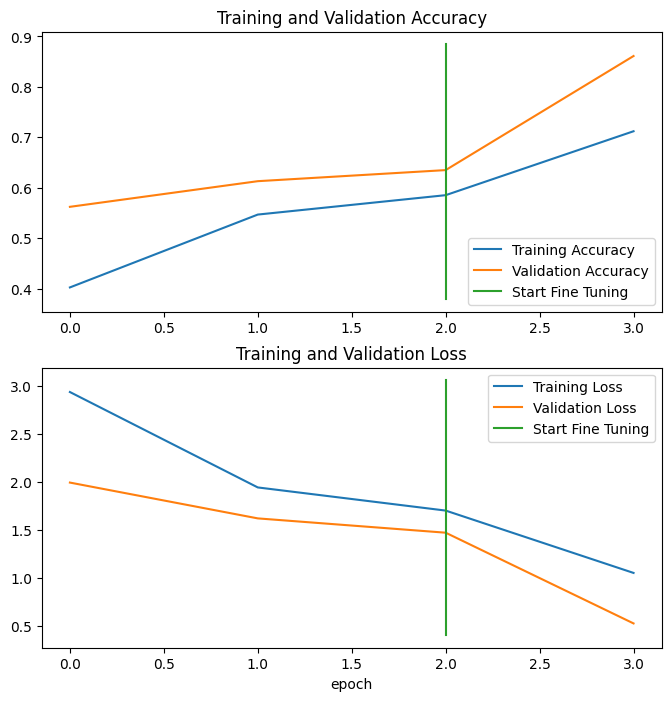

In [89]:
compare_historys(history_B4_feature_extraction, history_B4_fine_tuning, initial_epochs=3)

# Summary
- Our model fine tuned with EfficientNetB4 (89,2% accuracy) did better than EfficientNetB0 (Obviously).
- Our fine tuned model with EfficientNetB0 overfits a bit.